# Diabetes or not: A Comprehensive Analysis of Diabetical Symptoms in Pima Indians Diabetes Database #

### by Brian Adhitya, Wyatt Howell, Brian Ko, Nishanth Selvakumar

### Introduction

Diabetes is a common and chronic condition characterized by high blood sugar levels. It occurs when the body can't produce enough insulin or can't use it effectively. There are different types of diabetes, including Type 1, where the immune system attacks insulin-producing cells, and Type 2, usually linked to insulin resistance. Diabetes is a major global health concern, leading to complications like heart diseases, kidney issues, vision problems, and nerve damage. Lifestyle factors and genetics contribute to its development. Management involves medication, lifestyle changes, and regular monitoring. Due to its widespread impact, diabetes is a focus of ongoing research and public health efforts. In recent years in Canada, almost 1 in 10 adults from age 20 - 79 are diabetic, and of those adults aged 60 - 79 diabetes occurs in 1 in 5 (Statcan). 

This dataset provides insight into diabetic diagnosis based on certain health factors for women over the age of 21 of Pima Indian heritage. The Pima is a Native American group situated in southern Arizona, USA. The health factors include the amount of pregnancies, glucose concentration (orally tested), blood pressure, skin thickness, BMI, diabetes pedigrees function, insulin level, and age. Understanding the health factors that are prevalent in diabetic patients is essential for developing treatment methods. Using these factors we will be able to notice trends, patterns, and relationships and use these to predict the diabetic outcome of an undiagnosed patient. This dataset will inform people of what health factors could possibly lead to diabetes at a later age. 

The question we are trying to answer is: **How will other health factors influence glucose, and diabetes diagnosis?**

### Loading libraries

In [1]:
# importing libraries
library(tidyverse)
library(repr)
library(janitor)
library(ggplot2)
library(tidymodels)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ──────

### Preeliminary exploratory data analysis

**1. Loading and cleaning the Dataset**

In [2]:
# Cleaning names and specifying categorical variable
diabetes <- read_csv("data/diabetes.csv") |>
            clean_names() |>
            mutate(outcome = as_factor(outcome)) |>
            mutate(diabetes = fct_recode(outcome, "Yes" = "1", "No" = "0")) |>
            select(-outcome)

# Displaying the data
head(diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,Yes
1,85,66,29,0,26.6,0.351,31,No
8,183,64,0,0,23.3,0.672,32,Yes
1,89,66,23,94,28.1,0.167,21,No
0,137,40,35,168,43.1,2.288,33,Yes
5,116,74,0,0,25.6,0.201,30,No


**2. Splitting into testing and training**

In [3]:
# splitting the diatabes data
diabetes_split <- initial_split(diabetes, prop = 0.75, strata = diabetes)

# training data
diabetes_training <- training(diabetes_split)

# testing data
diabetes_testing <- testing(diabetes_split)

# the data to be used
head(diabetes_training)

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,116,74,0,0,25.6,0.201,30,No
10,115,0,0,0,35.3,0.134,29,No
4,110,92,0,0,37.6,0.191,30,No
10,139,80,0,0,27.1,1.441,57,No
1,103,30,38,83,43.3,0.183,33,No
3,126,88,41,235,39.3,0.704,27,No


**3. Cleaning and wrangling data**

In [4]:
# Summarizing the age data
diabetes_summary_age <- diabetes_training |>
                        group_by(diabetes) |>
                        summarize(min_age = min(age, na.rm = TRUE),
                                max_age = max(age, na.rm = TRUE),
                                mean_age = mean(age, na.rm = TRUE))

# Summarizing the glucose level data
diabetes_summary_glucose <- diabetes_training |>
                            group_by(diabetes) |>
                            summarize(min_glucose = min(glucose, na.rm = TRUE),
                                      max_glucose = max(glucose, na.rm = TRUE),
                                      mean_glucose = mean(glucose, na.rm = TRUE))

# Summarize the pregnancies data
diabetes_summary_pregnancies <- diabetes_training |>
                            group_by(diabetes) |>
                            summarize(min_pregnancies = min(pregnancies, na.rm = TRUE),
                                      max_pregnancies = max(pregnancies, na.rm = TRUE),
                                      mean_pregnancies = mean(pregnancies, na.rm = TRUE))

# joining all the summaries into a dataframe
diabetes_summary <- full_join(diabetes_summary_age, diabetes_summary_glucose, by = "diabetes") |>
                    full_join(diabetes_summary_pregnancies, by = "diabetes")

# displaying the data
head(diabetes_summary)

diabetes,min_age,max_age,mean_age,min_glucose,max_glucose,mean_glucose,min_pregnancies,max_pregnancies,mean_pregnancies
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,21,81,31.11467,56,197,111.6720,0,13,3.328000
Yes,21,70,37.23881,0,197,143.0647,0,17,4.875622


**4. Visualizing some key points**

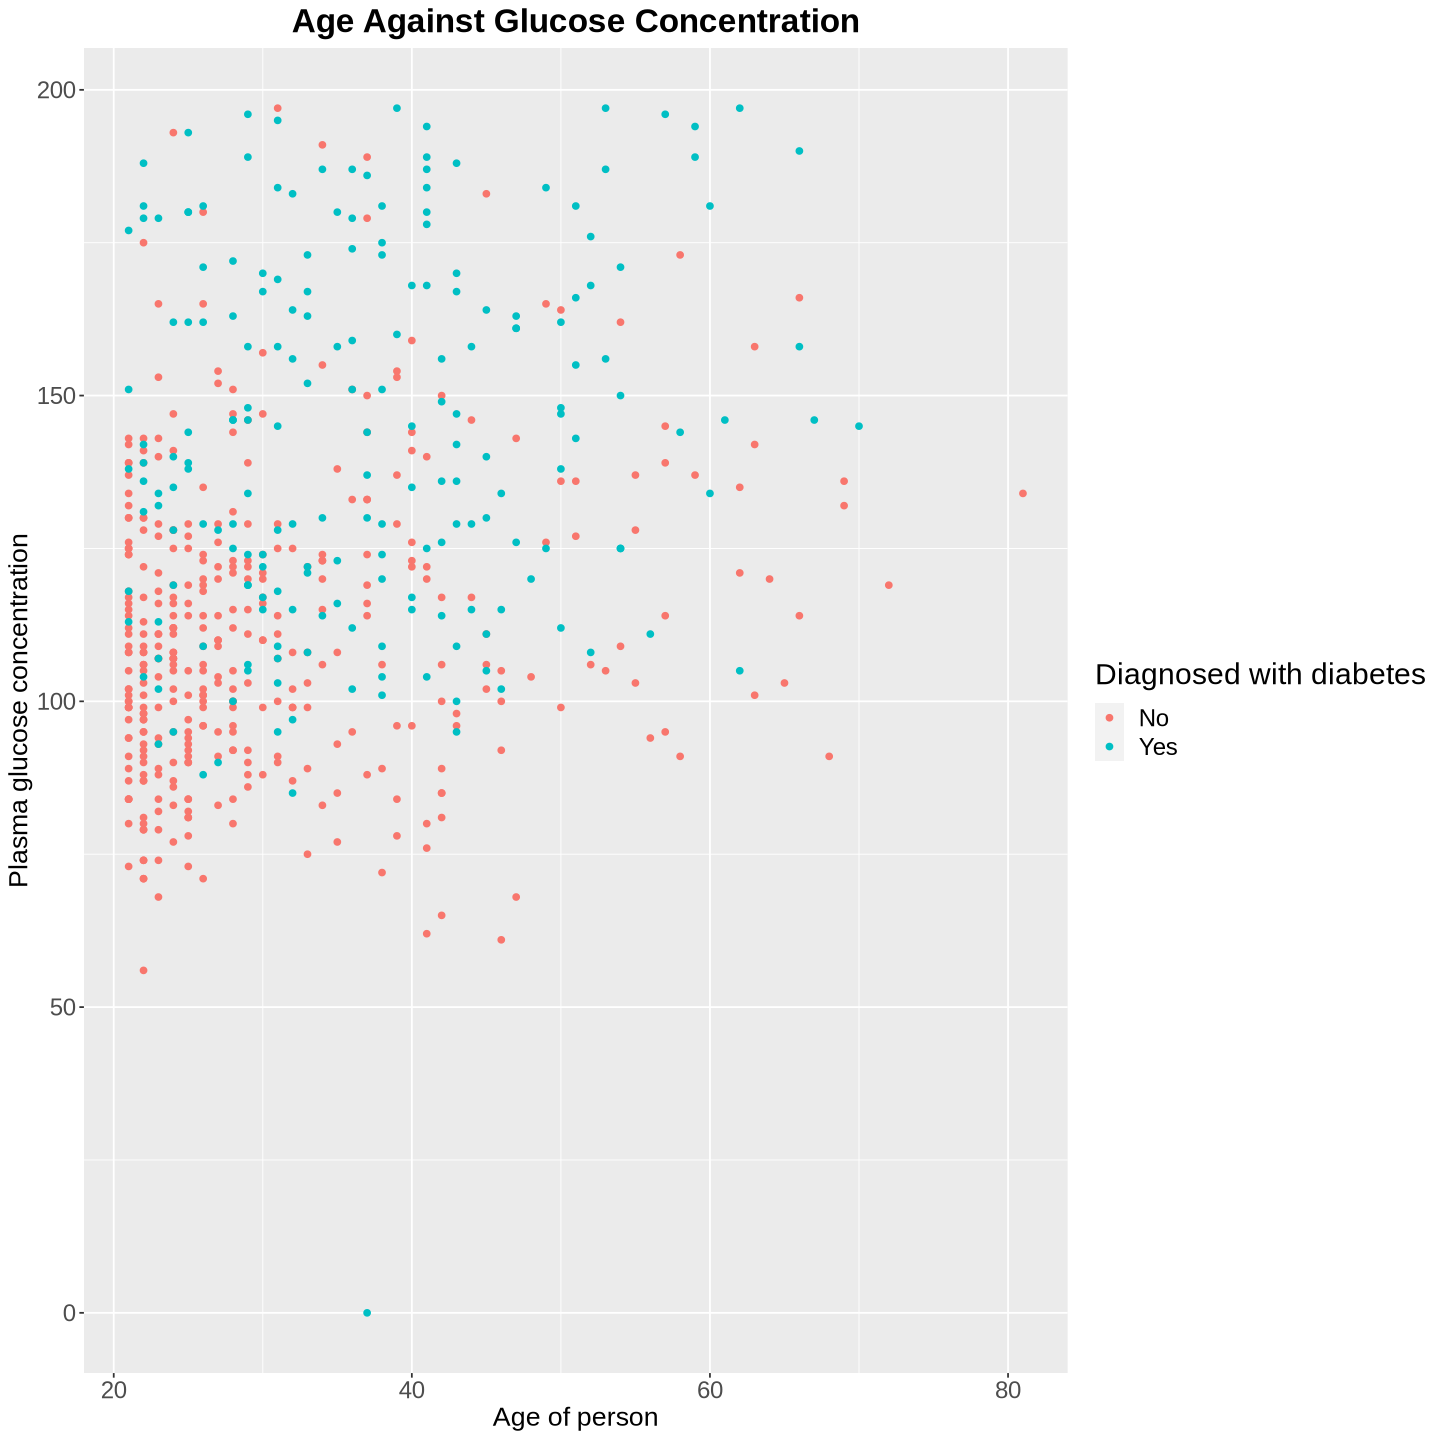

In [5]:
options(repr.plot.width = 12, repr.plot.height = 12)

diabetes_age_plot <- diabetes_training |>
                    ggplot(aes(x = age, y = glucose, color = diabetes)) +
                    geom_point(alpha = 1.5) +
                    xlab("Age of person") +
                    ylab("Plasma glucose concentration") +
                    labs(color = "Diagnosed with diabetes") +
                    ggtitle("Age Against Glucose Concentration") +
                    theme(text = element_text(size = 18),
                          plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
                          axis.title.x = element_text(size = 16),
                          axis.title.y = element_text(size = 16))

diabetes_age_plot

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


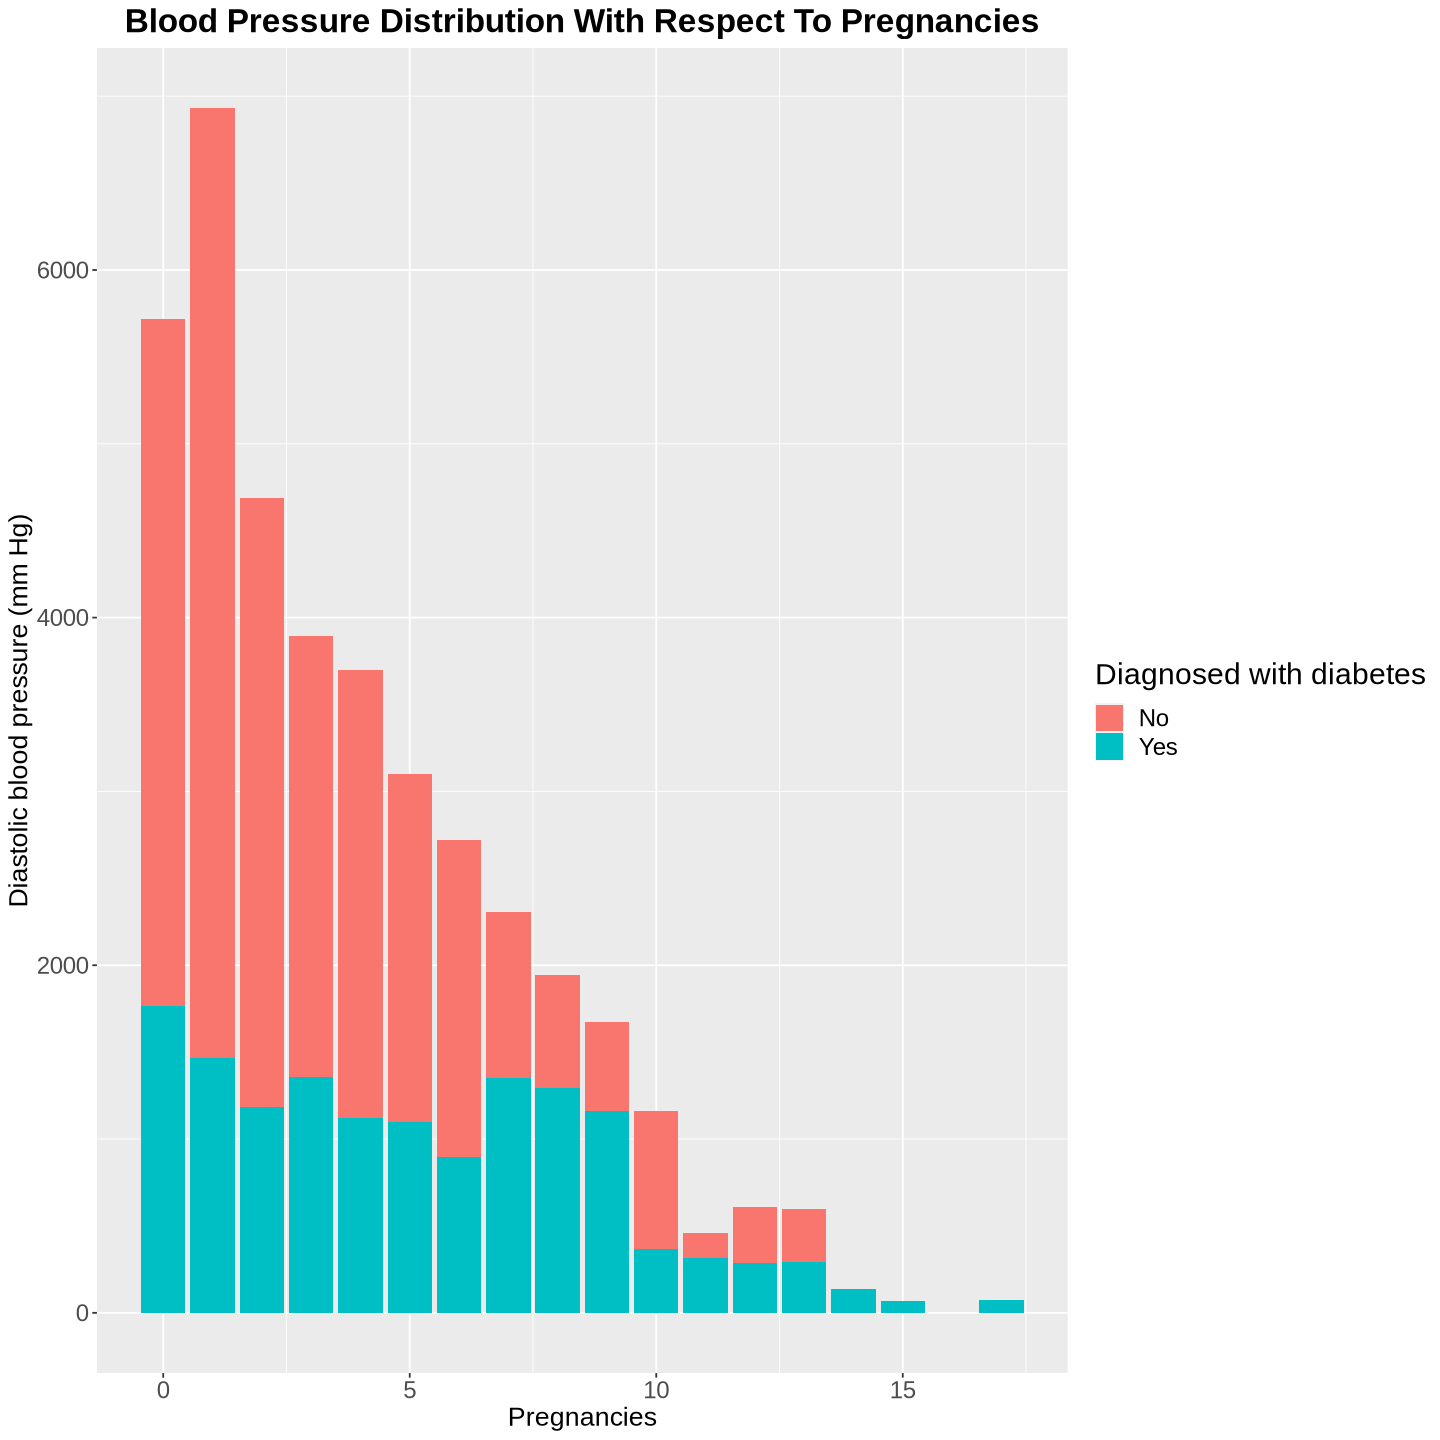

In [30]:
options(repr.plot.height = 12, repr.plot.width = 12)

diabetes_pressure_plot <- diabetes_training |> 
    ggplot(aes(x = pregnancies, y = blood_pressure, fill=diabetes)) + 
    geom_histogram(stat="identity") + 
    labs(x = "Pregnancies",
         y = "Diastolic blood pressure (mm Hg)",
         title = "Blood Pressure Distribution With Respect To Pregnancies",
         fill = "Diagnosed with diabetes") +
    theme(text = element_text(size = 18),
                          plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
                          axis.title.x = element_text(size = 16),
                          axis.title.y = element_text(size = 16))
diabetes_pressure_plot

### Methods

Based on the dataset source in **kaggle** (https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database), we can classify the columns as below:

1. **pregnancies** - Number of times pregnant 
2. **glucose** - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. **blood pressure** - Diastolic blood pressure (mm Hg)
4. **skin thickness** - Triceps skin fold thickness (mm)
5. **insulin** - 2-Hour serum insulin (mu U/ml)
6. **bmi** - Body mass index (weight in kg/(height in m)^2)
7. **diabetic pedigree function** - Diabetes pedigree function
8. **age** - Age (years)
9. **diabetes** - Class variable (0 or 1) 268 of 768 are 1, the others are 0


### Expected Outcomes and Significance

What we would like to find:
- How does blood pressure impact the likelihood of diabetes?
- What is the relationship of BMI and diabetic standing?
- What is the relationship between Glucose and Age with an emphasis on their Diabetic Standing?
  

Such findings will be able to create a much bigger impact in the future, such as ...

Some future questions that this could lead to include:
1. Question 1
2. Question 2
3. Question 3

### Bibliography

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.